In [18]:
import numpy as np

def omp_regression(X, y, T):
    N, D = X.shape
    A = set()  
    B = set(range(D))  
    residuals = np.copy(y)
    solutions = np.zeros((D, T))

    for t in range(T):
        correlations = np.abs(X[:, list(B)].T @ residuals)
        j = list(B)[np.argmax(correlations)]
        A.add(j)
        B.remove(j)
        X_active = X[:, list(A)]
        beta_t = np.linalg.lstsq(X_active, y, rcond=None)[0]
        residuals = y - X_active @ beta_t
        solutions[list(A), t] = beta_t

    return solutions


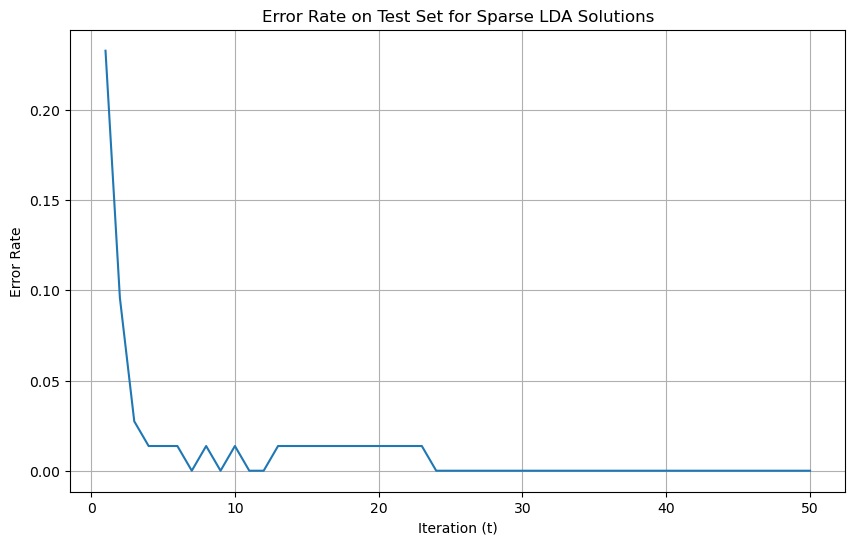

In [19]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

digits = load_digits()

X = digits.data
y = digits.target

X = X[(y == 3) | (y == 9)]
y = y[(y == 3) | (y == 9)]
y = np.where(y == 3, 1, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def omp_regression(X, y, T):
    N, D = X.shape
    A = np.array([], dtype=int)   
    B = np.arange(D)              
    solutions = np.zeros((D, T))

    residual = y.copy()

    for t in range(T):
        max_corr = 0
        max_corr_idx = -1

        for j in B:
            corr = np.abs(X[:, j].T @ residual)
            if corr > max_corr:
                max_corr = corr
                max_corr_idx = j

        A = np.append(A, max_corr_idx)
        B = np.delete(B, np.argwhere(B == max_corr_idx))

        X_active = X[:, A]
        beta = np.linalg.lstsq(X_active, y, rcond=None)[0]
        solutions[A, t] = beta

        residual = y - X_active @ beta

    return solutions

T = 50
solutions = omp_regression(X_train, y_train, T)

error_rates = []
for t in range(T):
    active_pixels = np.nonzero(solutions[:, t])[0]
    if len(active_pixels) > 0:
        X_active = X_train[:, active_pixels]
        X_test_active = X_test[:, active_pixels]
        beta = np.linalg.lstsq(X_active, y_train, rcond=None)[0]
        y_pred = np.sign(X_test_active @ beta)
        error_rate = np.sum(y_pred != y_test) / len(y_test)
        error_rates.append(error_rate)
    else:
        error_rates.append(1.0)  
plt.figure(figsize=(10, 6))
plt.plot(range(1, T + 1), error_rates)
plt.xlabel('Iteration (t)')
plt.ylabel('Error Rate')
plt.title('Error Rate on Test Set for Sparse LDA Solutions')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Error Rate on Test Set')

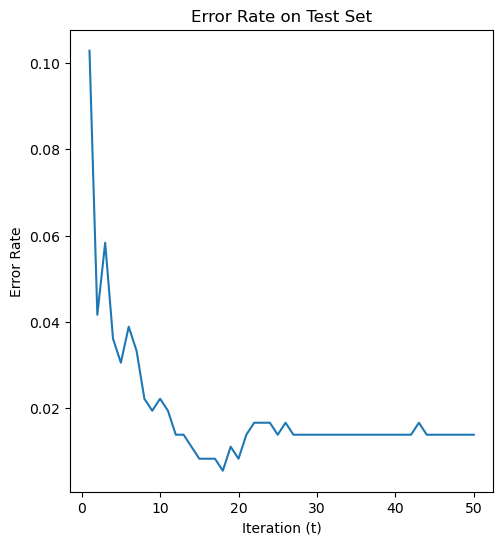

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

digits = load_digits()

X = digits.images.reshape(len(digits.images), -1)
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

y_train_binary = np.where(y_train == 3, 1, -1)
y_test_binary = np.where(y_test == 3, 1, -1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

T = 50
solutions = omp_regression(X_train, y_train_binary, T)

error_rates = []
for t in range(T):
    active_pixels = np.nonzero(solutions[:, t])[0]
    X_train_selected = X_train[:, active_pixels]
    X_test_selected = X_test[:, active_pixels]

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_selected, y_train_binary)
    y_pred = lda.predict(X_test_selected)
    error_rate = 1 - accuracy_score(y_test_binary, y_pred)
    error_rates.append(error_rate)

voting_preference = np.sign(solutions)
pixel_order = np.argsort(np.abs(solutions).sum(axis=1))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, T + 1), error_rates)
plt.xlabel('Iteration (t)')
plt.ylabel('Error Rate')
plt.title('Error Rate on Test Set')




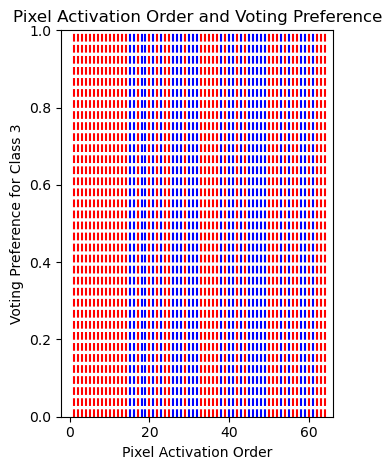

In [21]:
plt.subplot(1, 2, 2)
for i, pixel in enumerate(pixel_order):
    color = 'blue' if voting_preference[pixel, -1] == 1 else 'red'
    plt.axvline(i + 1, color=color, linestyle='--')
plt.xlabel('Pixel Activation Order')
plt.ylabel('Voting Preference for Class 3')
plt.title('Pixel Activation Order and Voting Preference')
plt.tight_layout()
plt.show()

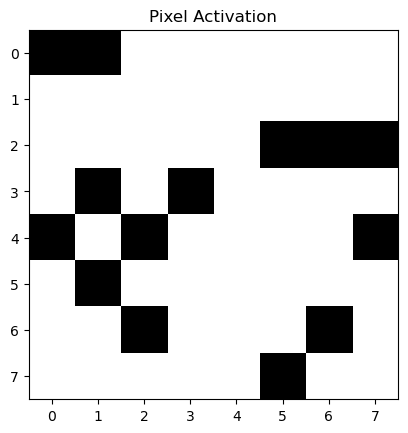

In [22]:
active_indices = np.nonzero(solutions[:, T-1])[0]  # Use the last iteration
active_pixels = np.zeros(X.shape[1])
active_pixels[active_indices] = 1
active_pixels = active_pixels.reshape(digits.images[0].shape)

plt.imshow(active_pixels, cmap='gray')
plt.title('Pixel Activation')
plt.show()